#### Datasets

**train_set.csv**: in the training dataset you will find a list of hotels and hotel characteristics. Every row has a unique identifier for the hotel - the hotel_id. The column n_clicks specifies the number of clicks the hotel has received in a specified time frame. This is the target variable you have to predict.
Number of rows: 396487.

**test_set.csv**: in the test set you will find a list of new hotels with the same characteristics as in the training set and derived in the same time frame. In this dataset the target variable that you have to predict is missing.
Number of rows: 132162.

**sample_submission.csv**: an example submission file. It should contain only the unique hotel_ids from the test set and the number of predicted clicks.


The training dataset provided is not clean and may be missing data or contain nonsensical values. Also, the datasets below contain potentially hashed and/or modified values. 



#### Evaluation

The predictions will be evaluated by a normalized weighted mean square error. Find more details in the resource section.

#### Column description

**hotel_id**: a number uniquely identifying each hotel

**city_id**: describes the city the hotel is located in

**content_score**: describes the quality of the content that is provided 
for the hotel on a scale from 0 (worst) to 100 (best)

**n_images**: number of images that are available for the given hotel

**distance_to_center**: distance (in meters) of the hotel to the nearest city center

**avg_rating**: average rating of the hotel on a scale from 0 (worst) to 100 (best)

**n_reviews**: number of reviews that are available for that hotel

**avg_rank**: average position the hotel had in the list

**avg_price**: average price in Euro of the hotel

**avg_saving_percent**: average saving users achieve on this hotel by using aggregator, i.e. the relative difference between the cheapest and most expensive deal for the hotel

**n_clicks**: the number of clicks the hotel has received in a specific time frame (target variable, unique to the training set)

In [1]:
import numpy as np
import pandas as pd
import itertools
from matplotlib import pyplot as plt
from collections import Counter
import seaborn as sns
sns.set()

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, AdaBoostRegressor,GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.metrics import accuracy_score, r2_score 

In [2]:
# Train data

df = pd.read_csv("../Hotel_Clicks_Prediction/train_set.csv")
df.head(5)

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
0,9.767406e+10,134520.0,70.0,2.0,1199.0,77.0,4.0,861.0,17.550,81.64,18.0,0
1,9.768889e+10,133876.0,67.0,3.0,12585.0,90.0,4.0,4371.0,17.383,189.38,28.0,4
2,9.811544e+10,133732.0,39.0,3.0,23491.0,83.0,3.0,1005.0,16.438,57.63,27.0,44
3,9.824279e+10,43772.0,59.0,8.0,3291.0,73.0,2.0,3084.0,7.000,72.16,2.0,4
4,9.833438e+10,50532.0,66.0,1.0,288.0,80.0,0.0,603.0,12.564,173.25,0.0,10


In [3]:
# Test data

data_test = pd.read_csv("../Hotel_Clicks_Prediction/test_set.csv")
IDtest = data_test["hotel_id"]
data_test.head(5)

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent
0,14942256073,122750.0,58.0,2.0,11503.0,89.0,0.0,168.0,13.500,90.19,32.0
1,16036037903,28134.0,68.0,4.0,938.0,81.0,5.0,735.0,13.667,98.27,19.0
2,288585940112,30578.0,19.0,0.0,38982.0,NaN,0.0,0.0,20.462,48.77,0.0
3,129041645070,54398.0,47.0,0.0,1683.0,80.0,0.0,69.0,15.000,72.32,0.0
4,12460296563,63890.0,59.0,3.0,1299.0,80.0,3.0,1470.0,10.000,24.54,19.0


In [4]:
# Check how clean our test and train data

data_test.isnull().sum(),df.isnull().sum()

(hotel_id                  0
 city_id                 155
 content_score           155
 n_images                156
 distance_to_center      163
 avg_rating            36630
 stars                   175
 n_reviews               163
 avg_rank                  0
 avg_price                58
 avg_saving_percent       58
 dtype: int64, hotel_id                   0
 city_id                  508
 content_score            508
 n_images                 509
 distance_to_center       529
 avg_rating            110398
 stars                    562
 n_reviews                529
 avg_rank                   0
 avg_price                170
 avg_saving_percent       170
 n_clicks                   0
 dtype: int64)

In [5]:
# Test data has one column less

df.shape, data_test.shape

((396487, 12), (132162, 11))

In [6]:
len(df.hotel_id.unique()),len(data_test.hotel_id.unique())

(396487, 132162)

The number of unique hotel_id is equal to the number of samples, which along with zero Nan values on the column indicates that dataset contains no hotel repetitions. As the result, I think that this feature can further be neglected for  analysis

In [7]:
df = df.drop(['hotel_id'], axis=1)
data_test = data_test.drop(['hotel_id'], axis=1)


In [8]:
len(df.city_id.unique())

33214

Drop the rows where all of the elements are nan. As one can see there are no such rows.

In [9]:
df = df.dropna(axis=0, how='all')
df.shape

(396487, 11)

### 1) Exploratory data analysis

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396487 entries, 0 to 396486
Data columns (total 11 columns):
city_id               395979 non-null float64
content_score         395979 non-null float64
n_images              395978 non-null float64
distance_to_center    395958 non-null float64
avg_rating            286089 non-null float64
stars                 395925 non-null float64
n_reviews             395958 non-null float64
avg_rank              396487 non-null float64
avg_price             396317 non-null float64
avg_saving_percent    396317 non-null float64
n_clicks              396487 non-null int64
dtypes: float64(10), int64(1)
memory usage: 36.3 MB


In [11]:
# Lets have a look at statistics of train set, to look for outliers.

df.describe()

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
count,395979.000000,395979.000000,3.959780e+05,3.959580e+05,286089.000000,395925.000000,395958.000000,396487.000000,396317.000000,396317.000000,396487.000000
mean,149193.465376,50.992795,2.593212e+02,1.634383e+04,81.616525,1.159659,913.667419,14.694502,109.332048,7.179601,13.781980
std,219189.285044,11.563444,1.731682e+04,2.752200e+05,6.025140,1.619713,2432.494160,5.604578,148.198851,13.081529,123.572896
min,2.000000,7.000000,-1.000000e+00,0.000000e+00,34.000000,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000
25%,32014.000000,45.000000,0.000000e+00,5.440000e+02,79.000000,0.000000,0.000000,11.091000,51.050000,0.000000,0.000000
50%,55122.000000,53.000000,1.000000e+00,1.516000e+03,83.000000,0.000000,189.000000,15.000000,77.650000,0.000000,0.000000
75%,137464.000000,59.000000,2.000000e+00,4.163000e+03,86.000000,3.000000,777.000000,18.375000,120.930000,10.000000,2.000000
max,878736.000000,81.000000,2.393911e+06,1.834155e+07,97.000000,5.000000,283089.000000,100.000000,8000.000000,99.000000,13742.000000


From the brief data description we could easily detect number of outliers, for instance in `n_images` and `n_reviews` columns. Therefore the reasonable step is to get rid of them. The max values for `n_clicks` and `avg_price` can also be tested

In [12]:
df["n_clicks"].min(),df["n_clicks"].max()

(0, 13742)

In [13]:
df[df['n_clicks']>10000]

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
119549,13278.0,63.0,6.0,294.0,86.0,5.0,15828.0,5.297,137.70,30.0,11652
143912,30512.0,63.0,1.0,4857.0,86.0,5.0,909.0,8.946,346.96,54.0,12790
201233,8582.0,66.0,12.0,1715.0,80.0,4.0,18861.0,9.603,109.85,18.0,10108
211064,170898.0,50.0,1.0,1317.0,82.0,5.0,339.0,4.471,143.88,22.0,10592
211753,8582.0,69.0,11.0,2058.0,86.0,4.0,13404.0,7.381,137.61,21.0,13742
395410,27328.0,60.0,5.0,811.0,85.0,4.0,2556.0,8.731,170.42,36.0,10458


In [14]:
df["avg_price"].min(),df["avg_price"].max()

(4.0, 8000.0)

In [15]:
df[df['avg_price']>7000]

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
29242,54398.0,47.0,0.0,6451.0,84.0,0.0,216.0,15.00,8000.00,0.0,0
107649,146568.0,19.0,0.0,53508.0,NaN,0.0,0.0,14.75,7162.37,0.0,0
155038,174248.0,42.0,0.0,11541.0,NaN,0.0,0.0,11.00,7773.74,0.0,0
240112,52306.0,42.0,0.0,2607.0,NaN,0.0,0.0,14.50,7741.74,0.0,0
314247,44036.0,42.0,0.0,1156.0,NaN,0.0,0.0,3.00,7957.34,0.0,0


Nothing extraordinary with these columns

Next step is analyze features a bit, to find which one correlates at most with `n_clicks`. Let say top-10 samples w.r.t `n_clicks`

city_id
7696.0     205858
8582.0     195422
55122.0    105106
13278.0     94864
3606.0      90344
27366.0     56060
34798.0     54218
44470.0     50838
18760.0     49128
27328.0     45106
Name: n_clicks, dtype: int64


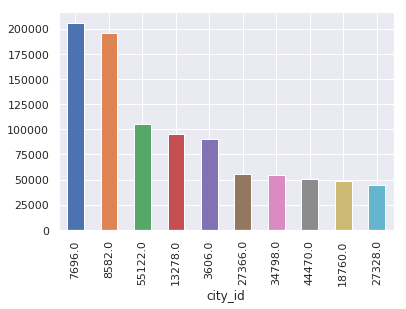

In [16]:
# top-10 cities with most number of clicks

df.groupby('city_id')['n_clicks'].sum().sort_values(ascending=False).iloc[:10].plot(kind='bar')
print(df.groupby('city_id')['n_clicks'].sum().sort_values(ascending=False).iloc[:10])

city_id
50168.0    192516.0
44470.0    121841.0
34798.0    110118.0
30576.0    101001.0
26874.0     83287.0
46884.0     72344.0
31786.0     72014.0
53222.0     64111.0
53604.0     60811.0
63440.0     58504.0
Name: avg_rating, dtype: float64


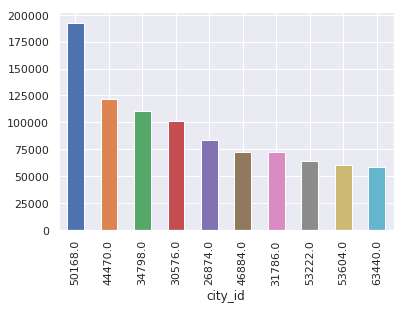

In [17]:
df.groupby('city_id')['avg_rating'].sum().sort_values(ascending=False).iloc[:10].plot(kind='bar')
print(df.groupby('city_id')['avg_rating'].sum().sort_values(ascending=False).iloc[:10])

We could see that the cities with the hotels having most `n_clicks` are not the same as those whose hotels have a higher rating. Therefore I don't think that `avg_rating` is an important feature for our analysis. 

Let us have a look on top - 10 values of distances to the center feature.
I would expect to have in top-10 very small values (short distance to the center is more
attractive, hence more clickable)

distance_to_center
0.0       20050
294.0     14682
2058.0    13958
4857.0    13566
811.0     12818
1317.0    12806
1017.0    11838
741.0     11478
936.0     11204
1537.0    10750
Name: n_clicks, dtype: int64


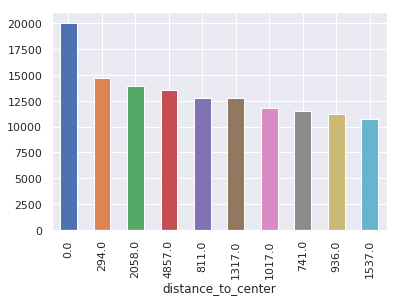

In [18]:
df.groupby('distance_to_center')['n_clicks'].sum().sort_values(ascending=False).iloc[:10].plot(kind='bar')
print(df.groupby('distance_to_center')['n_clicks'].sum().sort_values(ascending=False).iloc[:10])

To spped up the features analysis we will check the correlation between numerical features in our data set between themselves and the number of clicks. This information is important to know as there are Machine Learning algorithms (for example, linear and logistic regression) that do not handle highly correlated input variables well.

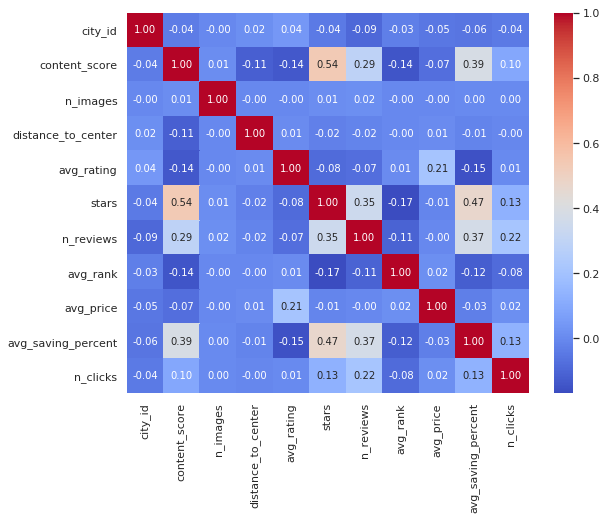

In [19]:
plt.figure(figsize=(9, 7))
g = sns.heatmap(df[[ u'city_id', u'content_score', u'n_images',
       u'distance_to_center', u'avg_rating', u'stars', u'n_reviews',
       u'avg_rank', u'avg_price', u'avg_saving_percent', u'n_clicks']].corr(), 
                annot=True,fmt = ".2f", cmap = "coolwarm")

A few features seems to correlate with `n_clicks`: `n_reviews`, `avg_saving_percent`,`content_score`,`stars`,`avg_rank`. Therefore we would expect it to have a big contribution to the classification.  

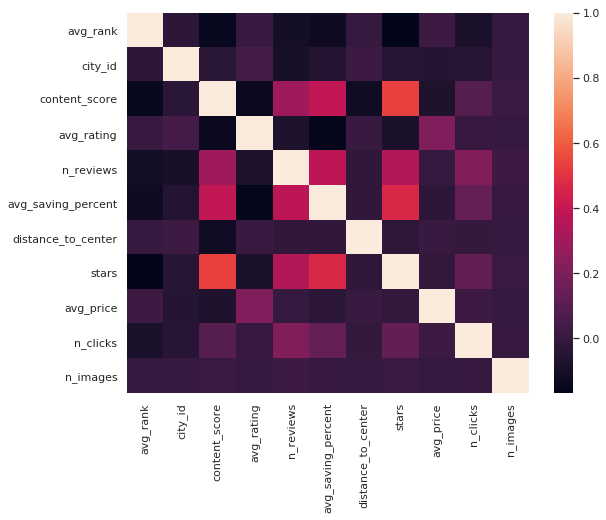

In [20]:
plt.figure(figsize=(9, 7))
numerical = list(set(df.columns))
corr_matrix = df[numerical].corr()
sns.heatmap(corr_matrix)

From these two correlation matrices, we could see that feature `stars` highly correlates with: `n_reviews`, `content score`,`saving percent` (multicollinearity hypothesis). At the same time, exactly these features correlate at most with `n_clicks`. So maybe it makes sense to experiment with deleting this column from a set.  Well, we do see a number of outliers from the box plots, however, would be correct to analyze is statistically through IQR.

In [21]:
# Coming back to outliers

#sns.boxplot(x=df['n_images'])

In [22]:
#sns.boxplot(x=df['n_reviews'])

Well, we do see a number of outliers from the box plots, however, would be correct to analyze is statistically through IQR. Combine train and test in order delete outliers

In [23]:
# Analyze outliers with H- spread

def outliers(df):

    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    print(IQR)
    
    df_clear = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
    df_clear.reset_index(drop=True, inplace=True)
    
    return df_clear

In [24]:
data_train = outliers(df)
data_train.shape

city_id               105450.000
content_score             14.000
n_images                   2.000
distance_to_center      3619.000
avg_rating                 7.000
stars                      3.000
n_reviews                777.000
avg_rank                   7.284
avg_price                 69.880
avg_saving_percent        10.000
n_clicks                   2.000
dtype: float64


(182689, 11)

In [25]:
data_train.isnull().sum()

city_id                 348
content_score           348
n_images                349
distance_to_center      355
avg_rating            59162
stars                   382
n_reviews               355
avg_rank                  0
avg_price                92
avg_saving_percent       92
n_clicks                  0
dtype: int64

Train data is being dramatically reduced due to removing outlier. Later, a more subtle approach can be tested as a hypothesis. , for now, we proceed with reliable Tukey method. The column `avg_rank` has the most missing values, therefore we need to think about data imputation.

### 2) Filling missing values

In [26]:
train_len = len(data_train)
dataset =  pd.concat(objs=[data_train, data_test], axis=0).reset_index(drop=True)
dataset.head(5)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,avg_price,avg_rank,avg_rating,avg_saving_percent,city_id,content_score,distance_to_center,n_clicks,n_images,n_reviews,stars
0,81.64,17.550,77.0,18.0,134520.0,70.0,1199.0,0.0,2.0,861.0,4.0
1,96.70,18.391,87.0,0.0,52142.0,58.0,1249.0,0.0,2.0,1683.0,0.0
2,99.41,20.451,87.0,8.0,63296.0,56.0,391.0,2.0,2.0,198.0,0.0
3,49.12,18.640,88.0,0.0,138802.0,50.0,603.0,0.0,0.0,141.0,0.0
4,21.38,19.000,NaN,0.0,208612.0,48.0,1795.0,0.0,1.0,0.0,0.0


In [27]:
# Reindex colums since pd.concat reorder columns (the reason is that we creating 
# DataFrames out of dictionaries. Dictionaries are a unordered which means the keys do 
# not have a specific order.) 

dataset = dataset.reindex_axis(data_train.columns, axis = 1)
dataset.head(5)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  """


,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
0,134520.0,70.0,2.0,1199.0,77.0,4.0,861.0,17.550,81.64,18.0,0.0
1,52142.0,58.0,2.0,1249.0,87.0,0.0,1683.0,18.391,96.70,0.0,0.0
2,63296.0,56.0,2.0,391.0,87.0,0.0,198.0,20.451,99.41,8.0,2.0
3,138802.0,50.0,0.0,603.0,88.0,0.0,141.0,18.640,49.12,0.0,0.0
4,208612.0,48.0,1.0,1795.0,NaN,0.0,0.0,19.000,21.38,0.0,0.0


In [28]:
dataset.isnull().sum()

city_id                  503
content_score            503
n_images                 505
distance_to_center       518
avg_rating             95792
stars                    557
n_reviews                518
avg_rank                   0
avg_price                150
avg_saving_percent       150
n_clicks              132162
dtype: int64

We can see that the majority of columns have a relatively small amount of zero values. Therefore they can be replaced by mean value without loss of precision. However, in `avg_rating` column, almost 45% of values are missed. Simply replacing it with a mean of column maybe not the best strategy. What can be done is median `avg_rating` of similar rows according to `content_score`, `avg_price` and `avg_saving_percent` (most correlated with `avg_rating` features accorfin to correlation matrix)

#### 2.1) First approach. 

We will get rid of all samples that contain any Nan values. That can only be conducted separately on the train set.

In [29]:
data_train_cleared_nan = data_train.dropna().reset_index(drop=True)
data_train_cleared_nan.shape

(123489, 11)

In [30]:
data_train_cleared_nan.isnull().sum()

city_id               0
content_score         0
n_images              0
distance_to_center    0
avg_rating            0
stars                 0
n_reviews             0
avg_rank              0
avg_price             0
avg_saving_percent    0
n_clicks              0
dtype: int64

After removing we have lost around 30% of the train data, let us see if we could conduct more subtle imputation.

#### 2.2) Second approach

Lets start with subtle imputation of `avg_rating` column with median avg_rating of similar rows according to `avg_price`,`content_score`,`avg_saving_percent`. These columns were chosen according to the correlation matrix above, a feature which are most correlated with `avg_rating`.

In [31]:
dataset.isnull().sum()

city_id                  503
content_score            503
n_images                 505
distance_to_center       518
avg_rating             95792
stars                    557
n_reviews                518
avg_rank                   0
avg_price                150
avg_saving_percent       150
n_clicks              132162
dtype: int64

In [32]:
index_Nan_Avg_rating = list(dataset['avg_rating'][dataset['avg_rating'].isnull()].index)
print(len(index_Nan_Avg_rating))

95792


In [33]:
for i in index_Nan_Avg_rating:
    
    rating_med = dataset['avg_rating'].median()
    rating_pred = dataset['avg_rating'][((dataset['avg_price'] == dataset.iloc[i]['avg_price']) & 
                               (dataset['content_score'] == dataset.iloc[i]['content_score']) & 
                              (dataset['avg_saving_percent'] == dataset.iloc[i]['avg_saving_percent']))].median()
   
    if not np.isnan(rating_pred) :
        dataset['avg_rating'].iloc[i] = rating_pred
        
    else :
        dataset['avg_rating'].iloc[i] = rating_med
        
print(dataset['avg_rating'])

/upb/users/s/ssmirnov/profiles/unix/imt/.local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1019: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0         77.0
1         87.0
2         87.0
3         88.0
4         83.0
5         80.0
6         79.0
7         87.0
8         83.0
9         82.0
10        83.0
11        76.0
12        81.0
13        87.0
14        84.0
15        82.0
16        86.0
17        83.0
18        79.0
19        73.0
20        91.0
21        83.0
22        87.0
23        81.0
24        85.0
25        86.0
26        82.0
27        78.0
28        76.0
29        79.0
          ... 
314821    78.0
314822    88.0
314823    81.0
314824    85.0
314825    83.0
314826    76.0
314827    83.0
314828    85.0
314829    84.0
314830    82.0
314831    86.0
314832    82.0
314833    83.0
314834    87.0
314835    83.0
314836    82.0
314837    83.0
314838    86.0
314839    83.0
314840    81.0
314841    86.0
314842    84.0
314843    76.0
314844    88.0
314845    86.0
314846    84.0
314847    86.0
314848    79.0
314849    85.0
314850    85.0
Name: avg_rating, Length: 314851, dtype: float64


In [34]:
dataset.isnull().sum()

city_id                  503
content_score            503
n_images                 505
distance_to_center       518
avg_rating                 0
stars                    557
n_reviews                518
avg_rank                   0
avg_price                150
avg_saving_percent       150
n_clicks              132162
dtype: int64

Since the small proportion of the data is missing and we have already removed outliers, lets use 'mean' for imputation.

In [35]:
dataset_imputed_nan = dataset.fillna(dataset.mean())
dataset_imputed_nan.isna().sum()

city_id               0
content_score         0
n_images              0
distance_to_center    0
avg_rating            0
stars                 0
n_reviews             0
avg_rank              0
avg_price             0
avg_saving_percent    0
n_clicks              0
dtype: int64

In [36]:
# Save the obtained data

dataset_imputed_nan.to_csv('dataset_imputed_nan.csv',sep=',')

We cleared the data and now it makes sense to train some models to see which data imputation approach is giving a better result and to choose proper learning algorithm.

### 3) Baseline Training model

In [37]:
# We need to split our 'dataset' back into train and test 

data_train_impured_nan = dataset_imputed_nan[:train_len]
data_test = dataset_imputed_nan[train_len:].reset_index(drop=True)

# delete simulated 'n_clicks' from test set

data_test.drop(['n_clicks'], axis=1, inplace=True)

In [38]:
dataset_imputed_nan['n_clicks'] = dataset_imputed_nan['n_clicks'].astype('int64') 
dataset_imputed_nan.head(5)

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
0,134520.0,70.0,2.0,1199.0,77.0,4.0,861.0,17.550,81.64,18.0,0
1,52142.0,58.0,2.0,1249.0,87.0,0.0,1683.0,18.391,96.70,0.0,0
2,63296.0,56.0,2.0,391.0,87.0,0.0,198.0,20.451,99.41,8.0,2
3,138802.0,50.0,0.0,603.0,88.0,0.0,141.0,18.640,49.12,0.0,0
4,208612.0,48.0,1.0,1795.0,83.0,0.0,0.0,19.000,21.38,0.0,0


In [39]:
data_train_cleared_nan.head(5)

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
0,134520.0,70.0,2.0,1199.0,77.0,4.0,861.0,17.550,81.64,18.0,0
1,52142.0,58.0,2.0,1249.0,87.0,0.0,1683.0,18.391,96.70,0.0,0
2,63296.0,56.0,2.0,391.0,87.0,0.0,198.0,20.451,99.41,8.0,2
3,138802.0,50.0,0.0,603.0,88.0,0.0,141.0,18.640,49.12,0.0,0
4,54248.0,50.0,0.0,5954.0,80.0,0.0,102.0,15.686,51.19,0.0,2


In [40]:
data_train_impured_nan.shape, data_test.shape

((182689, 11), (132162, 10))

In [41]:
# Make a distionary with features

def features_importance(df):

    Y = df.iloc[:,-1]
    X = df.drop([df.columns[-1]], axis=1)
    
    X_train, X_holdout, y_train, y_holdout = train_test_split(X.values, Y, test_size=0.3,
    random_state=17)
    
    features = {
    "f1":u'city_id', 
    "f2":u'content_score', 
    "f3":u'n_images',
    "f4":u'distance_to_center', 
    "f5":u'avg_rating', 
    "f6":u'stars', 
    "f7":u'n_reviews',
    "f8":u'avg_rank', 
    "f9":u'avg_price', 
    "f10":u'avg_saving_percent'}
    
    forest = RandomForestRegressor(n_estimators=1000, max_features=10,
                                    random_state=0,n_jobs=6)
    
    forest.fit(X_train,
               y_train)
    
    importances = forest.feature_importances_
    
    indices = np.argsort(importances)[::-1]
    
    # Plot the feature importancies of the forest
    num_to_plot = 10
    feature_indices = [ind+1 for ind in indices[:num_to_plot]]
    
    # Print the feature ranking
    print("Feature ranking:")
      
    for f in range(num_to_plot):
        print("%d. %s %f " % (f + 1, 
                features["f"+str(feature_indices[f])], 
                importances[indices[f]]))
    plt.figure(figsize=(15,5))
    plt.title(u"Feature Importance")
    bars = plt.bar(range(num_to_plot), 
                   importances[indices[:num_to_plot]],
           color=([str(i/float(num_to_plot+1)) 
                   for i in range(num_to_plot)]),
                   align="center")
    ticks = plt.xticks(range(num_to_plot), 
                       feature_indices)
    plt.xlim([-1, num_to_plot])
    plt.legend(bars, [u''.join(features["f"+str(i)]) 
                      for i in feature_indices]);

Feature ranking:
1. avg_rank 0.185970 
2. city_id 0.159259 
3. avg_price 0.138318 
4. distance_to_center 0.135464 
5. n_reviews 0.122970 
6. content_score 0.080839 
7. avg_rating 0.078568 
8. avg_saving_percent 0.040924 
9. n_images 0.033636 
10. stars 0.024051 


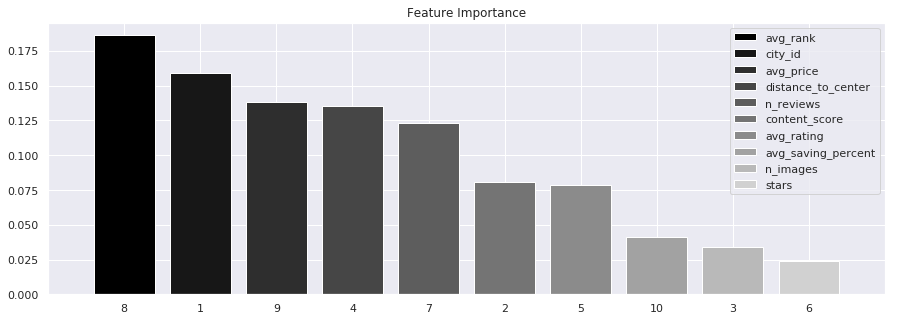

In [42]:
# Let us compare the feature importance for both data cleaning approaches

features_importance(data_train_cleared_nan)

Feature ranking:
1. avg_rank 0.197800 
2. city_id 0.164698 
3. avg_price 0.145732 
4. distance_to_center 0.142285 
5. n_reviews 0.109720 
6. content_score 0.080049 
7. avg_rating 0.071136 
8. avg_saving_percent 0.036633 
9. n_images 0.030203 
10. stars 0.021743 


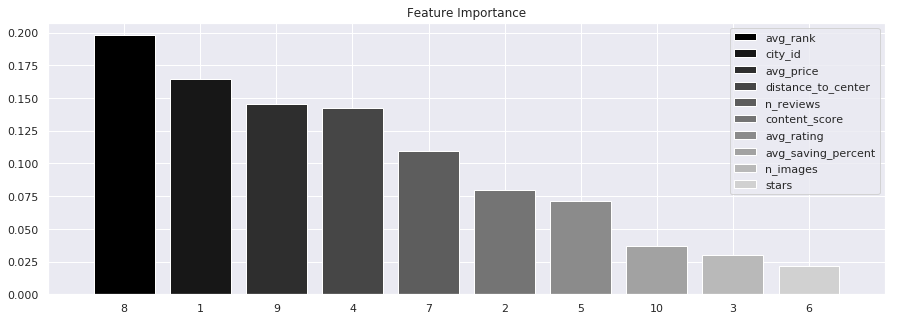

In [43]:
features_importance(data_train_impured_nan)

By performing sklearn in-built feature performance analysis on our both training sets we see that according to the basic Random Forest model the most important features w.r.t `n_clicks` are: `avg_rank`,`city_id`,`avg_price`,`distance to the center`,`n_reviews`. Let us recall our correlation matrix and features which we thought would be helpful for classification: `n_reviews`, `avg_saving_percent`,`content_score`,`stars`,`avg_rank`. The once can see along with the feature we would expect to have `avg_rank` and `n_reviews` RF defined other two features to be relevant: `city_id`,`avg_price to the center`,`distance to the center`.
I believe that one of the reasons why the results are differ is because of the parameters of the classifier. The model we took are very simple and supposed to be tuned.

### 4) Modeling

In this section, we will build some models and test them. We start with very two simple algorithms DT and KNN in order to establish some baseline and to test whether imputation of 'Nan' is better than just simply deleting 'Nan's' rows.

In [44]:
# Firstly, we need to normalize our data since some of the classification algorithms
# are quite sensitive


columns_to_norm = ['city_id', u'content_score', u'n_images', u'distance_to_center',
       u'avg_rating', u'stars', u'n_reviews', u'avg_rank', u'avg_price',
       u'avg_saving_percent']

data_train_cleared_nan_norm = data_train_cleared_nan[columns_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
data_train_cleared_nan_norm = pd.concat([data_train_cleared_nan_norm, data_train_cleared_nan['n_clicks']],axis=1);

data_train_impured_nan_norm = data_train_impured_nan[columns_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
data_train_impured_nan_norm = pd.concat([data_train_impured_nan_norm, data_train_impured_nan['n_clicks']],axis=1);

In [45]:
data_train_cleared_nan_norm.head(5)

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
0,0.452564,0.836364,0.500000,0.125013,0.296296,0.8,0.425837,0.585841,0.350171,0.72,0
1,0.172603,0.618182,0.500000,0.130226,0.666667,0.0,0.862839,0.615611,0.418095,0.00,0
2,0.210510,0.581818,0.500000,0.040767,0.666667,0.0,0.073365,0.688531,0.430318,0.32,2
3,0.467116,0.472727,0.166667,0.062871,0.703704,0.0,0.043062,0.624425,0.203500,0.00,0
4,0.179760,0.472727,0.166667,0.620790,0.407407,0.0,0.022329,0.519858,0.212836,0.00,2


In [46]:
def simple_classific_models(df):
    
    
    Y = df.iloc[:,-1]
    X = df.drop([df.columns[-1]], axis=1)

    X_train, X_holdout, y_train, y_holdout = train_test_split(X.values, Y, test_size=0.3,
    random_state=17)    
    
    # Cross validate model with Kfold stratified cross val

    random_state = 17
    
    
    tree = DecisionTreeClassifier(random_state=random_state)
    knn = KNeighborsClassifier()
    forest = RandomForestClassifier(random_state=random_state)
    
    tree.fit(X_train, y_train)
    knn.fit(X_train, y_train)
    forest.fit(X_train, y_train)
    
    tree_pred = tree.predict(X_holdout)
    knn_pred = knn.predict(X_holdout)
    forest_pred = forest.predict(X_holdout)
    
    print(accuracy_score(y_holdout, tree_pred), accuracy_score(y_holdout, knn_pred),accuracy_score(y_holdout, forest_pred))

Firstly, we tested which train dataset (cleared or imputed) gives a better result and we could see that with the big margin imputed dataset is better, hence we continue with it. Secondly, we see that KNN and RF outperform simple DT, but since the parameters are taken **by default** we treat the obtain data carefully. It will benefit a lot to conduct hyperparameter tuning. 

In [47]:
simple_classific_models(data_train_cleared_nan_norm),simple_classific_models(data_train_impured_nan_norm)

/upb/users/s/ssmirnov/profiles/unix/imt/.local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(0.6290387885658758, 0.7302615596404567, 0.7420034010851081)
(0.6744211505829547, 0.7685332165599285, 0.779553706643312)


(None, None)

**Since our target variable is sort of continuous, therefore it would make sense to tackle the problem as Regression one**

In [48]:
def simple_regression_models(df):
    
    
    Y = df.iloc[:,-1]
    X = df.drop([df.columns[-1]], axis=1)

    X_train, X_holdout, y_train, y_holdout = train_test_split(X.values, Y, test_size=0.3,
    random_state=17)    
    
    # Cross validate model with Kfold stratified cross val

    random_state = 17
    
    
    tree = DecisionTreeRegressor(random_state=random_state)
    knn = KNeighborsRegressor(n_neighbors=10)
    forest = RandomForestRegressor(random_state=random_state)
    
    tree.fit(X_train, y_train)
    knn.fit(X_train, y_train)
    forest.fit(X_train, y_train)

    tree_pred = tree.predict(X_holdout)
    knn_pred = knn.predict(X_holdout)
    forest_pred = forest.predict(X_holdout)
    
    # R2 score
    
    print(r2_score(y_holdout, tree_pred), r2_score(y_holdout, knn_pred), r2_score(y_holdout, forest_pred))

In [49]:
simple_regression_models(data_train_cleared_nan_norm),simple_regression_models(data_train_impured_nan_norm)

(-0.8755485298521575, -0.01974966188256655, -0.0009429827676121771)
(-0.8222956033147077, -0.005433031633151009, 0.003887794184842641)


(None, None)

Regression analysis proved again the aforementioned conclusions. So now lets just take RF and obtain our first baseline prediction.

In [50]:
data_test.head(5)

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent
0,122750.0,58.0,2.0,11503.0,89.0,0.0,168.0,13.500,90.19,32.0
1,28134.0,68.0,4.0,938.0,81.0,5.0,735.0,13.667,98.27,19.0
2,30578.0,19.0,0.0,38982.0,83.0,0.0,0.0,20.462,48.77,0.0
3,54398.0,47.0,0.0,1683.0,80.0,0.0,69.0,15.000,72.32,0.0
4,63890.0,59.0,3.0,1299.0,80.0,3.0,1470.0,10.000,24.54,19.0


In [51]:
# Lets obtain first (baseline) prediction for the test set

data_train = data_train_impured_nan_norm

Y = data_train.iloc[:,-1]
X = data_train.drop([data_train.columns[-1]], axis=1)
random_state = 17
forest = RandomForestRegressor(random_state=random_state)
forest.fit(X, Y)
forest_pred = forest.predict(data_test)


In [52]:
len(forest_pred)

132162

In [53]:
test_clicks = pd.Series(np.rint(forest.predict(data_test)), name="n_clicks")

results = pd.concat([IDtest,test_clicks],axis=1)

results.to_csv('baseline_pred.csv', index=False)

Lets compare 11 popular regressors and evaluate the R Squared metric of each of them by a stratified kfold cross validation procedure.

- Decision Tree

- AdaBoost

- Random Forest

- Extra Trees

- Gradient Boosting

- Bagging

- KNN

- SVR

- Logistic regression

- Lasso Regression

- Ridge Regression

In [54]:
# Modeling step Test different algorithms 

kfold = StratifiedKFold(n_splits=10)

# Cross validate model with Kfold stratified cross val

regressors = []

regressors.append(DecisionTreeRegressor(random_state=random_state))
regressors.append(AdaBoostRegressor(DecisionTreeRegressor(random_state=random_state)))
regressors.append(RandomForestRegressor(random_state=random_state))
regressors.append(ExtraTreesRegressor(random_state=random_state))
regressors.append(GradientBoostingRegressor(random_state=random_state))
regressors.append(BaggingRegressor(random_state=random_state))
regressors.append(KNeighborsRegressor())
regressors.append(LinearSVR(random_state=random_state))
regressors.append(LogisticRegression(random_state = random_state))
regressors.append(linear_model.Lasso(random_state = random_state))
regressors.append(linear_model.Ridge(random_state = random_state))

In [55]:
%%time

Y = data_train.iloc[:,-1]
X = data_train.drop([data_train.columns[-1]], axis=1)


X_train, X_holdout, y_train, y_holdout = train_test_split(X.values, Y, test_size=0.3,
    random_state=17) 


cv_results = []
for regressor in regressors :
    print(regressor)
    cv_results.append(cross_val_score(regressor, X_train, y = y_train, scoring = "r2", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=17, splitter='best')
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=17, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=50,
         random_state=None)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_we

/upb/users/s/ssmirnov/profiles/unix/imt/.local/lib/python2.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=17,
         verbose=0, warm_start=False)
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')
LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=17, tol=0.0001, verbose=0)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=17,
   selection='cyclic', tol

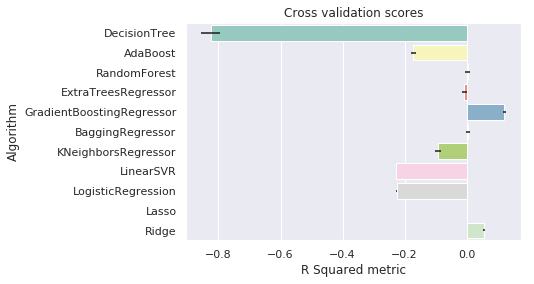

In [56]:
import seaborn as sns

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["DecisionTree","AdaBoost",
"RandomForest","ExtraTreesRegressor","GradientBoostingRegressor","BaggingRegressor","KNeighborsRegressor","LinearSVR","LogisticRegression","Lasso","Ridge"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("R Squared metric")
g = g.set_title("Cross validation scores")

GradientBoostingRegressor outperformed all other classifiers, therefore it would make sense to tune hyperparameters of it and obtain the highest "r2" score. **Unfortunately due to the lack of computational resources I couldn't perform such a heavy computation, however I provide the script that I would have used for this task**.

### Hyperparameter tuning for best models

In [ ]:
# Gradient boosting tunning

GBR = GradientBoostingRegressor()
gb_param_grid = {'loss' : ["ls","lad","huber"],
              'n_estimators' : [100,200,300,500],
              'learning_rate': [0.1, 0.01,0.001,0.0001],
              'max_depth': [8,16,32],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBR = GridSearchCV(GBR,param_grid = gb_param_grid, cv=kfold, scoring="r2", n_jobs= -1, verbose = 1)

gsGBR.fit(X,Y)

GBR_best = gsGBR.best_estimator_

# Best score

print(gsGBR.best_score_)
print(gsGBR.best_params_)

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [ ]:
test_clicks_GBR = pd.Series(GBR_best.predict(data_test), name="n_clicks")
results_ = pd.concat([IDtest,test_clicks_GBR],axis=1)

results.to_csv('GBR_pred.csv', index=False)